# Bayes from the Abyss: the Kalman Filter
## The Bayes rule hidden deep within your vertex and track fitting algorithms

The python implementation of the base method is by Mohamed Laaraiedh ( https://arxiv.org/abs/1204.0375 )

Modifications by Pietro Vischia (pietro.vischia@cern.ch:
- fixed imports (a few were missing)
- fixed access to numpy array shape (removed "()" )
- fixed a bug where the original algorithm was taking the predicted position as the new measured position with some random gaussian movement. Now we have:
    * a separate configurable true trajectory
    * a measured trajectory that consists in gaussian error around the true trajectory
    * a predicted trajectory that gets updated by the Kalman filter based on the measured trajectory
- plot the trajectory updates (the original code was missing this part)
- dynamically plot the trajectory updates

Prediction step

In [1]:
from numpy import dot

def kf_predict(X, P, A, Q, B, U):
    X = dot(A, X) + dot(B, U)
    P = dot(A, dot(P, A.T)) + Q
    return(X,P)




Update step

In [2]:
def kf_update(X, P, Z, H, R):
    IM = dot(H, X)
    IS = R + dot(H, dot(P, H.T))
    K = dot(P, dot(H.T, inv(IS)))
    X = X + dot(K, (Z-IM))
    P = P - dot(K, dot(IS, K.T))
    LH = gauss_pdf(Z, IM, IS)
    return (X,P,K,IM,IS,LH)

def gauss_pdf(X, M, S):
    if M.shape[1] == 1:
        DX = X - tile(M, X.shape[1])
        E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(det(S))
        P = exp(-E)
    elif X.shape[1] == 1:
        DX = tile(X, M.shape[1])- M
        E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(det(S))
        P = exp(-E)
    else:
        DX = X-M
        E = 0.5 * dot(DX.T, dot(inv(S), DX))
        E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(det(S))
        P = exp(-E)
    return (P[0],E[0])
    
    

In [3]:
from numpy import *
from numpy.linalg import inv, det
from numpy.random import randn

In [4]:
# Mobile use true trajectory (first step)
true = array([[0.0], [0.0]])

def true_trajectory(pos):
    return array([[pos[0,0] + 0.9*abs(randn(1)[0]) + 0.3*randn(1)[0]], [pos[1,0] + 0.5*abs(randn(1)[0]) + 0.1*randn(1)[0]]])
    
# The sensor on your phone tracks you with some gaussian noise
measured = array([[true[0,0] + abs(randn(1)[0])], [true[1,0] + abs(randn(1)[0])]])
# The Kalman filter predicts your trajectory based on the previous measurements. We begin with the first measurement
predicted = array([[measured[0,0]], [measured[1,0]],[0.1] , [0.1]])

#time step of mobile movement 
dt = 0.1
# Initialization of state matrices
P = diag((0.01, 0.01, 0.01, 0.01))
A = array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
Q = eye(predicted.shape[0])
B = eye(predicted.shape[0])
U = zeros((predicted.shape[0],1))

# Store history to show that we compute each state conditionally on the previous one
# without using all the states each time (that's why this a Kalman filter is better than e.g. a Wiener filter)
store_true=[]
store_measured=[]
store_predicted=[]


# Measurement matrices
H = array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = eye(measured.shape[0])
# Number of iterations in Kalman Filter
N_iter = 50
# Applying the Kalman Filter



for i in arange(0, N_iter):
    (predicted, P) = kf_predict(predicted, P, A, Q, B, U)
    (predicted, P, K, IM, IS, LH) = kf_update(predicted, P, measured, H, R)
    true= true_trajectory(true)
    measured= array([[true[0,0] + abs(randn(1)[0])],[true[1, 0] + abs(randn(1)[0])]])
    store_true.append(true)
    store_measured.append(measured)
    store_predicted.append(predicted)


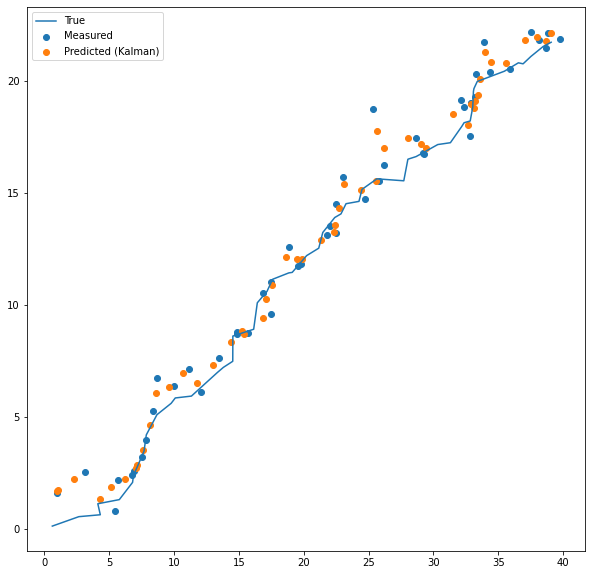

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np



# True trajectory
plt.figure(figsize=(10,10))
plt.plot(np.array(store_true)[:,0], np.array(store_true)[:,1], ls='-', label='True')
# Measured trajectory
plt.scatter(np.array(store_measured)[:,0], np.array(store_measured)[:,1], label='Measured')
# Predicted trajectory
plt.scatter(np.array(store_predicted)[:,0], np.array(store_predicted)[:,1], label='Predicted (Kalman)')

plt.legend(loc='best')

#### Now I do it live
of course thanks [https://stackoverflow.com/questions/39658717/plot-dynamically-changing-graph-using-matplotlib-in-jupyter-notebook](stackoverflow) for the help XDDD

For this to work you need to reload the kernel, and to avoid loading matplotlib before this cell (otherwise the notebook magic doesn't work)

<IPython.core.display.Javascript object>


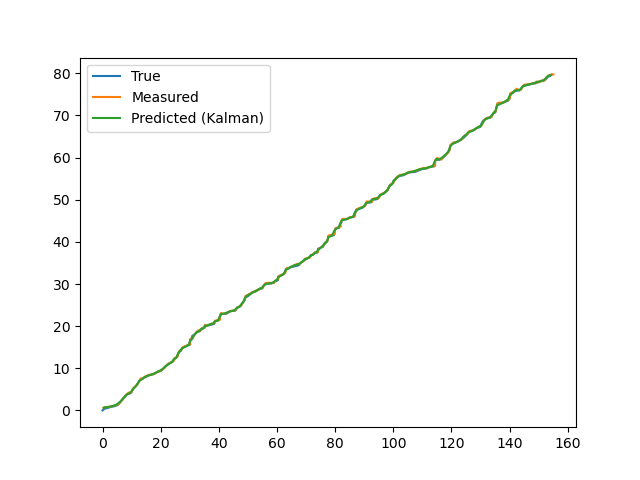

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import time
from threading import Thread

class LiveGraph:
    def __init__(self):
        self.true=array([[0.0], [0.0]])
        self.measured=array([[self.true[0,0] + abs(randn(1)[0])], [self.true[1,0] + abs(randn(1)[0])]])
        self.predicted=array([[self.measured[0,0]], [self.measured[1,0]],[0.1] , [0.1]])
        self.store_true=[self.true]
        self.store_measured=[self.measured]
        self.store_predicted=[self.predicted]
        self.figure = plt.figure()
        self.ptrue, = plt.plot(np.array(self.store_true)[:,0], np.array(self.store_true)[:,1], ls='-', label='True')
        self.pmeas, = plt.plot(np.array(self.store_measured)[:,0], np.array(self.store_measured)[:,1], label='Measured')
        self.ppred, = plt.plot(np.array(self.store_predicted)[:,0], np.array(self.store_predicted)[:,1], label='Predicted (Kalman)')
        plt.legend(loc='best')
        self.th = Thread(target=self.thread_f, daemon=True)
        self.th.start()

    def true_trajectory(self,pos):
        return array([[pos[0,0] + 0.9*abs(randn(1)[0]) + 0.00*randn(1)[0]], [pos[1,0] + 0.5*abs(randn(1)[0]) + 0.00*randn(1)[0]]])
        #return array([[pos[0,0] + 0.9*abs(randn(1)[0])], [ pos[1,0] + sin(pos[1,0]) + 0.5*abs(randn(1)[0]) + 0.05*randn(1)[0]]])

    def update_graph(self):
        self.ptrue.set_data(np.array(self.store_true)[:,0], np.array(self.store_true)[:,1])
        self.pmeas.set_data(np.array(self.store_measured)[:,0], np.array(self.store_measured)[:,1])
        self.ppred.set_data(np.array(self.store_predicted)[:,0], np.array(self.store_predicted)[:,1])
        self.figure.gca().relim()
        self.figure.gca().autoscale_view()


    def show(self):
        plt.show()

    def thread_f(self):
        dt = 0.001
        # Initialization of state matrices
        P = diag((0.01, 0.01, 0.01, 0.01))
        A = array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
        Q = eye(self.predicted.shape[0])
        B = eye(self.predicted.shape[0])
        U = zeros((self.predicted.shape[0],1)) 
        # Measurement matrices
        H = array([[1, 0, 0, 0], [0, 1, 0, 0]])
        R = eye(self.measured.shape[0])
        # Number of iterations in Kalman Filter
        N_iter = 500
        # Applying the Kalman Filter

        for i in arange(0, N_iter):
            (self.predicted, P) = kf_predict(self.predicted, P, A, Q, B, U)
            (self.predicted, P, K, IM, IS, LH) = kf_update(self.predicted, P, self.measured, H, R)
            self.true= self.true_trajectory(self.true)
            self.measured= array([[self.true[0,0] + 0.2*abs(randn(1)[0])],[self.true[1, 0] + 0.2*abs(randn(1)[0])]])
            self.store_true.append(self.true)
            self.store_measured.append(self.measured)
            self.store_predicted.append(self.predicted)

            self.update_graph()

            time.sleep(0.1)  



g = LiveGraph()
g.show()